<a href="https://colab.research.google.com/github/Krzesimir13/DataQuest/blob/main/heart_disease_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting heart desease by ML methods


---



##Project description

The project simulates working for an R&D company that focuses on providing healthcare solutions. The company has collected anonymized data from multiple hospitals on several patients. The dataset includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

The dataset has the following features:

`Age`: age of the patient *[years]*

`Sex`: sex of the patient *[M: Male, F: Female]*

`ChestPainType`: chest pain type *[TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]*

`RestingBP`: resting blood pressure *[mm Hg]*

`Cholesterol`: serum cholesterol *[mm/dl]*

`FastingBS`: fasting blood sugar *[1: if FastingBS > 120 mg/dl, 0: otherwise]*

`RestingECG`: resting electrocardiogram results *[Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]*

`MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]

`ExerciseAngina`: exercise-induced angina *[Y: Yes, N: No]*

`Oldpeak`: oldpeak = ST *[Numeric value measured in depression]*

`ST_Slope`: the slope of the peak exercise ST segment *[Up: upsloping, Flat: flat, Down: downsloping]*

`HeartDisease`: output class *[1: heart disease, 0: Normal]*

##1. Preparing the environment and the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
np.set_printoptions(precision=3, suppress=False)
pd.options.display.precision = 3

*Uploading the data from Kaggle*

In [3]:
!pip -q install kagglehub

In [4]:
import kagglehub
import os

path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
os.listdir(path)

Using Colab cache for faster access to the 'heart-failure-prediction' dataset.


['heart.csv']

In [5]:
raw_data = pd.read_csv(os.path.join(path, 'heart.csv'))
heart = raw_data.copy()

##2. Preparing the dataset

###2.1. The general preview

In [6]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [8]:
heart.describe(include=['int', 'float'])

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000,918.000,918.000,918.000,918.000,918.000,918.000
mean,53.511,132.397,198.800,0.233,136.809,0.887,0.553
std,9.433,18.514,109.384,0.423,25.460,1.067,0.497
min,28.000,0.000,0.000,0.000,60.000,-2.600,0.000
25%,47.000,120.000,173.250,0.000,120.000,0.000,0.000
50%,54.000,130.000,223.000,0.000,138.000,0.600,1.000
75%,60.000,140.000,267.000,0.000,156.000,1.500,1.000
max,77.000,200.000,603.000,1.000,202.000,6.200,1.000


Observations:

No missing values

Average age : 53.5

Some 0 values in `Cholesterol` and `RestingBP` - not measured?

###2.2. Target distribution

In [9]:
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

heart[categorical_cols].value_counts()

Sex  ChestPainType  RestingECG  ExerciseAngina  ST_Slope
M    ASY            Normal      Y               Flat        109
     ATA            Normal      N               Up           64
     ASY            Normal      N               Flat         55
                    ST          Y               Flat         49
     NAP            Normal      N               Up           46
                                                           ... 
     TA             LVH         Y               Flat          1
                                                Up            1
                    Normal      Y               Up            1
                    ST          N               Down          1
                                Y               Flat          1
Name: count, Length: 95, dtype: int64

Unique values in categorical columns:

In [10]:
{col : heart[col].unique().tolist() for col in categorical_cols}

{'Sex': ['M', 'F'],
 'ChestPainType': ['ATA', 'NAP', 'ASY', 'TA'],
 'RestingECG': ['Normal', 'ST', 'LVH'],
 'ExerciseAngina': ['N', 'Y'],
 'ST_Slope': ['Up', 'Flat', 'Down']}

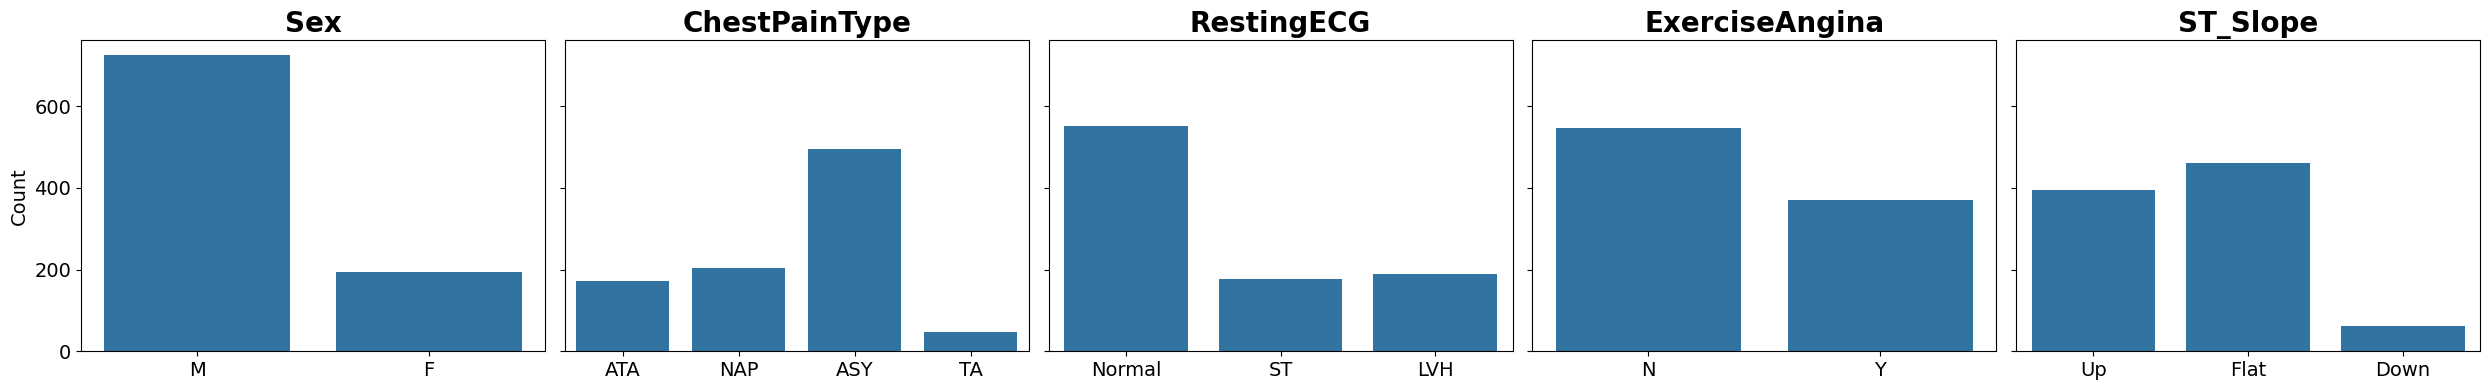

In [11]:
n_cols = len(categorical_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4), sharey=True)

for i, col in enumerate(categorical_cols):
  sns.countplot(x=col, data=heart, ax=axes[i])
  axes[i].set_title(col, fontsize=20, fontweight='bold')
  axes[i].set_xlabel('')
  axes[i].tick_params(axis='both', labelsize=14)
  if i > 0:
    axes[i].set_ylabel('')
  else:
    axes[i].set_ylabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

In [12]:
pd.crosstab(heart['Sex'], heart['HeartDisease'])

HeartDisease,0,1
Sex,,
F,143,50
M,267,458


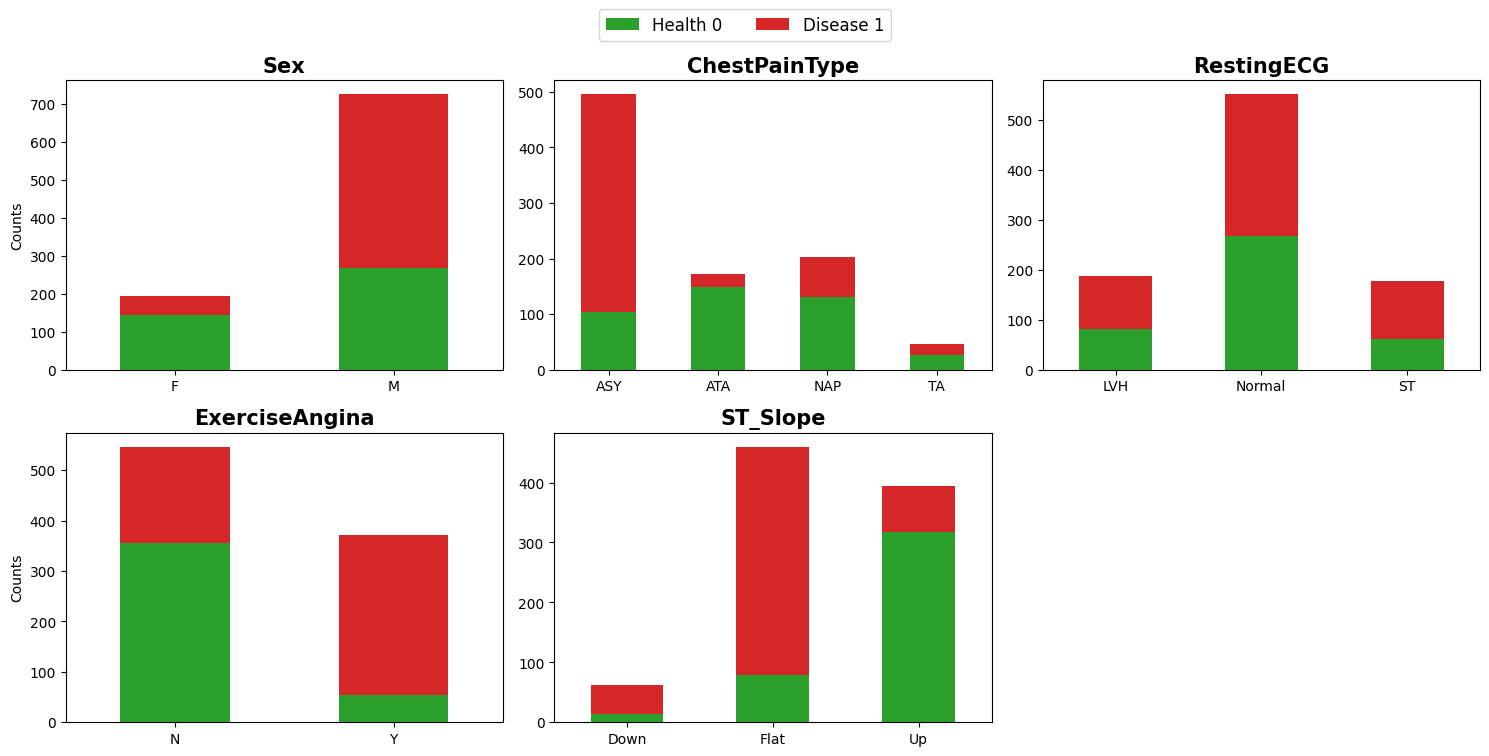

In [13]:
colors = ['#2ca02c', '#d62728']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
  ct = pd.crosstab(heart[col], heart['HeartDisease'])
  ct.plot(kind='bar', stacked=True, ax=axes[i], color=colors, legend=False)
  axes[i].set_title(col, fontsize=15, fontweight='bold')
  axes[i].tick_params(axis='x', rotation=0)
  axes[i].set_xlabel('')

  if i % 3 == 0:
    axes[i].set_ylabel('Counts')
  else:
    axes[i].set_ylabel('')

fig.delaxes(axes[-1])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Health 0', 'Disease 1'],
           loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

More sensible for heart disease:

* `Sex` : Men

* `ChestPainType` : Asymptomatic `ASY` pain type

* `ExerciseAngina` : Exercise-induced angina YES

* `ST slope` : `Flat` or `down`


---



The distribution of heart disease by age and sex.

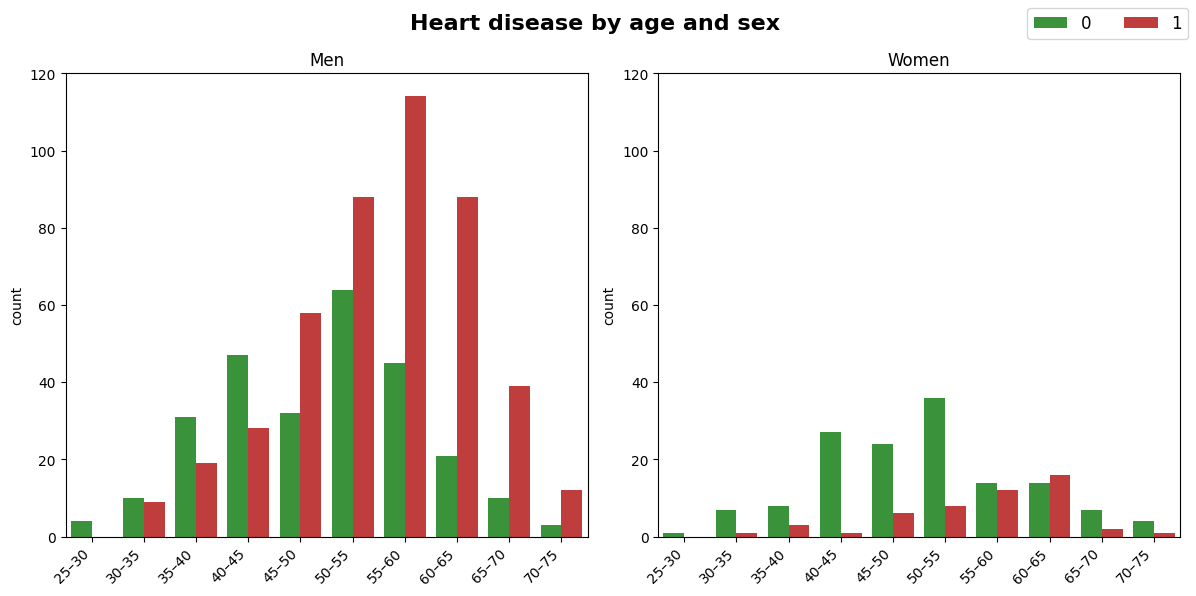

In [14]:
bins = range(25, 80, 5)

heart_man = heart.loc[heart['Sex'] == 'M'].copy()
heart_woman = heart.loc[heart['Sex'] == 'F'].copy()

heart_man['AgeBin']   = pd.cut(heart_man['Age'], bins=bins)
heart_woman['AgeBin'] = pd.cut(heart_woman['Age'], bins=bins)

xtickslabels = [
        f"{int(i.left)}–{int(i.right)}"
        for i in heart_man['AgeBin'].cat.categories
        ]


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=heart_man, x='AgeBin',
              ax=axes[0], hue='HeartDisease', palette=colors)
sns.countplot(data=heart_woman, x='AgeBin',
              ax=axes[1], hue='HeartDisease', palette=colors)

for ax in axes:
    ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylim(0, 120)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xticks(range(len(xtickslabels)))
    ax.set_xticklabels(xtickslabels)
    ax.set_xticklabels(xtickslabels, rotation=45, ha='right')

fig.suptitle('Heart disease by age and sex', fontsize=16, fontweight='bold')
axes[0].set_title('Men')
axes[1].set_title('Women')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, [0, 1], loc='upper right', ncol=2, fontsize=12, markerscale=1.5)

plt.tight_layout()
plt.show()

We see that distribution in men is totally different than in woman. More classified men have heart diseases, especially over 45 year. In woman, an at-risk group is 55-65 years.

Therefore, to fill the missing values, I divide man for two groups 45- and 45+ years old. Simirarly, woman are divided for 55- and 55+ groups. The groups are splitted by sex also.

###2.3. Filling the missing values

In [15]:
len(heart[heart['RestingBP'] == 0])

1

In [16]:
len(heart[heart['Cholesterol'] == 0])

172

In [17]:
heart = raw_data.copy()

In [18]:
heart[['RestingBP', 'Cholesterol']] = heart[['RestingBP', 'Cholesterol']].replace(0, np.nan)

In [19]:
heart['AgeGroup'] = np.where((heart['Sex'] == 'M') & (heart['Age'] >= 45) |
                             (heart['Sex'] == 'F') & (heart['Age'] >= 55),
                             'high', 'low'
                             )


In [20]:
heart[['RestingBP', 'Cholesterol']] = heart[['RestingBP', 'Cholesterol']].fillna(
    heart.groupby(['Sex', 'AgeGroup', 'HeartDisease'])[['RestingBP', 'Cholesterol']].\
    transform('mean')
)

###2.4. Encoding the categorical columns

In [21]:
heart = heart.drop('AgeGroup', axis=1)

In [22]:
heart_corr = pd.get_dummies(data=heart, columns=categorical_cols, dtype=int)

In [23]:
pearson = heart_corr.corr()[['HeartDisease']].abs().sort_values('HeartDisease',
                                                        ascending=False)
spearman = heart_corr.corr(method='spearman')[['HeartDisease']]\
  .abs().sort_values('HeartDisease', ascending=False)

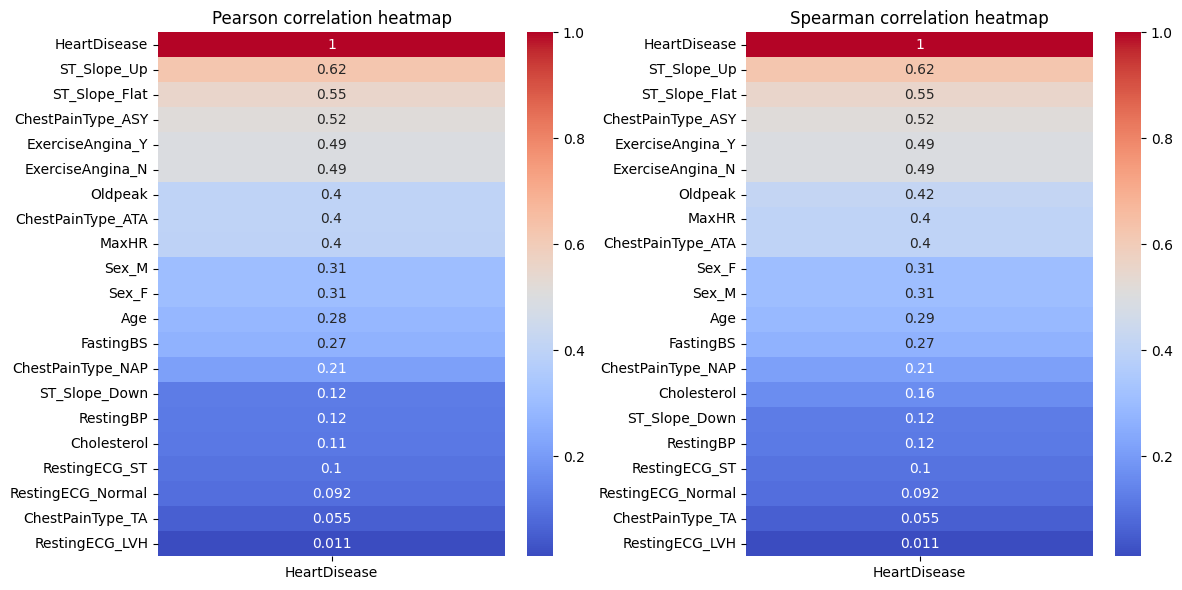

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(pearson, annot=True, cmap='coolwarm', ax=axes[0])
sns.heatmap(spearman, annot=True, cmap='coolwarm', ax=axes[1])
axes[0].set_title('Pearson correlation heatmap')
axes[1].set_title('Spearman correlation heatmap')

plt.tight_layout()
plt.show()

I will do two approaches:

1) Features selected by DataQuest: `Oldpeak`, `Sex`, `ExerciseAngina`, `ST_Slope`.

2) Features most highly correlated by heatmaps: `ST_Slope`, `ChestPainType`, `ExerciseAngina`, `Oldpeak`, `MaxHR`.

In [25]:
heart1 = heart_corr[['Oldpeak', 'Sex_M', 'ExerciseAngina_Y', 'ST_Slope_Flat',
                     'ST_Slope_Up', 'HeartDisease']]
heart2 = heart_corr[['Oldpeak', 'ChestPainType_ASY', 'ChestPainType_ATA',
  'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up', 'MaxHR', 'HeartDisease']]

##3. Building the model

###3.1. DQ-selected features

I will split dataset for train, validation and test sets in ratio 6:2:2.

In [81]:
data = heart1.drop(['HeartDisease'], axis=1).to_numpy()
target = heart1['HeartDisease']

In [82]:
print(data.shape)
print(target.shape)

(918, 5)
(918,)


In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=137)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=137)

In [61]:
features = list(heart1.columns)[:-1]
features

['Oldpeak', 'Sex_M', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']

Firstly, I will see the performance for every single feature.

In [84]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

for i, feature in enumerate(features):
  model = KNeighborsClassifier(n_neighbors=7)
  model.fit(X_train[:, [i]], y_train)
  y_pred = model.predict(X_val[:, [i]])
  accuracy = accuracy_score(y_val, y_pred)
  print(f'{feature} accuracy : {accuracy*100:.2f}%')

Oldpeak accuracy : 67.35%
Sex_M accuracy : 63.95%
ExerciseAngina_Y accuracy : 76.19%
ST_Slope_Flat accuracy : 74.15%
ST_Slope_Up accuracy : 78.91%


It seems than the accuracies are the same since 7 neighbours, I don't know why.
Accuracies for lower number of neighbours are lower, `ST_Slope_Up` even underperfomed.
In General, now I have moderate accuracies for all features.

---



Now, it's time to see the performance for all features.

Firstly, data must be standarised.

In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[:, [0]])
X_train[:, [0]] = scaler.transform(X_train[:, [0]])
X_val[:, [0]] = scaler.transform(X_val[:, [0]])
X_test[:, [0]] = scaler.transform(X_test[:, [0]])

In [86]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 80.27%


In [87]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy of the best model on the TEST SET: {accuracy*100:.2f}%')

Accuracy of the best model on the TEST SET: 82.07%


The highest accuracy was for 5 neigbours. In general, the overall accuracy is better than for single features.


---



Now, I will do cross-valitation of parameters.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=137)

scaler = StandardScaler()
scaler.fit(X_train[:, [0]])
X_train[:, [0]] = scaler.transform(X_train[:, [0]])
X_test[:, [0]] = scaler.transform(X_test[:, [0]])

In [76]:
from sklearn.model_selection import GridSearchCV

params = {
    'metric' : ['minkowski', 'manhattan', 'cosine', 'euclidean'],
    'weights' : ['uniform', 'distance'],
    'n_neighbors' : list(range(1, 20))
}

model = KNeighborsClassifier()

grid = GridSearchCV(model, params, scoring='accuracy')

grid.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan', 'cosine',
                                    'euclidean'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [77]:
print('Best parameters:', grid.best_params_)
print(f'Best score: {grid.best_score_*100:.2f}%')

Best parameters: {'metric': 'minkowski', 'n_neighbors': 15, 'weights': 'uniform'}
Best score: 84.33%


The best model's score tested on a train set.

In [78]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [80]:
print(f'Accuracy of the best model on the TEST SET: {accuracy*100:.2f}%')

Accuracy of the best model on the TEST SET: 85.33%
